In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv


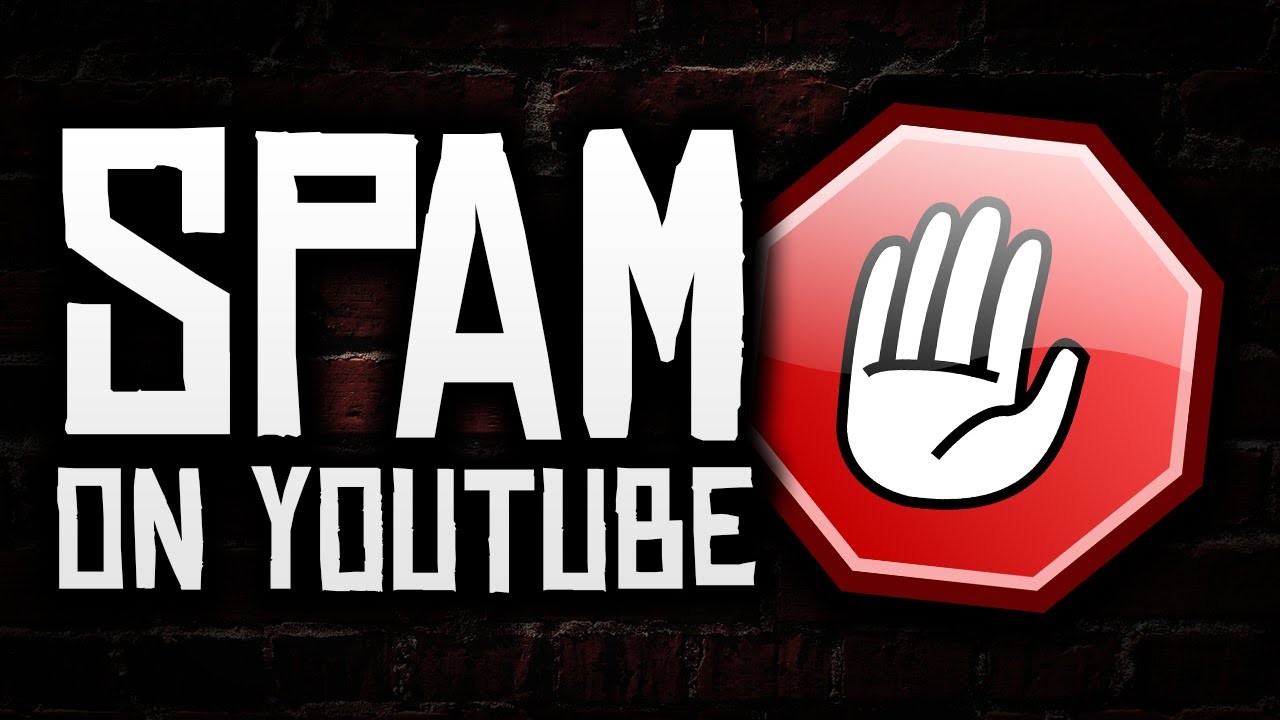

<div style="font-family: 'Playfair Display', serif;  letter-spacing: 0px; color:#808D7C; font-size:120%; padding:10px; background: #FBF7F7; border-radius: 3px;">
    <p style="font-size: 110%;color: black;">the datasets composed by 1,956 real messages extracted from five videos have class indicating if the comment is spam or not (1 = spam, 0 = not spam).</p>
</div>


# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Import Libraries</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import spacy
import re
nlp=spacy.load('en_core_web_sm')
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">EDA & Visualization</p>

In [3]:
data=pd.read_csv("/kaggle/input/youtube-comments-spam-dataset/Youtube-Spam-Dataset.csv")
data.sample(7)

COMMENT_ID  \
900             z12cvnpwzrmncblfm230ejjwpzvetrgl5   
881           z13wg12iskysxzuhi04cdhcxam2wdxfi4hk   
1627          z12wuxjqmqjbyjab404cidxofne4ftup35c   
1895  _2viQ_Qnc6_fFzltk8kvomVzwfkCdIZApG5fa2-gZRw   
1114        z125vphj5u3vw5rya04ch5eatpnwjjsg2u00k   
1636          z12csjyqqru3tvlcb22hz3vrrn3jzfzyg04   
1455          z12oczujeqz2xn2lq234ijdzurmdynx5m04   

                               AUTHOR                        DATE  \
900                     ROBLOX Gaming  2015-05-16T01:54:31.334000   
881                       Nina Mackie  2015-05-17T09:07:30.578000   
1627                    Trygve Nilsen  2015-05-25T19:48:16.265000   
1895                   Diaz Katherine  2013-08-17T21:11:39.761000   
1114                     Renee Nelson  2014-07-23T22:23:47.235000   
1636                   Thiago Andrade  2015-05-25T08:08:49.121000   
1455  Quinn and Mia Channel MattyB101  2015-05-21T22:48:59.766000   

                                                CONTENT  \
900                                                 :3﻿   
881       Take a look at this video on YouTub<br />You﻿   
1627  I felt old when I realized that this song was ...   
1895  Earn money for being online with 0 efforts!   ...   
1114                                        Good video﻿   
1636                           Nice vídeo shakira good﻿   
1455                                So freaking sad...﻿   

                                             VIDEO_NAME  CLASS  
900   LMFAO - Party Rock Anthem ft. Lauren Bennett, ...      0  
881   LMFAO - Party Rock Anthem ft. Lauren Bennett, ...      1  
1627                               Shakira - Waka Waka       0  
1895                               Shakira - Waka Waka       1  
1114  LMFAO - Party Rock Anthem ft. Lauren Bennett, ...      0  
1636                               Shakira - Waka Waka       0  
1455          Eminem - Love The Way You Lie ft. Rihanna      0

In [4]:
data.shape

(1956, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   VIDEO_NAME  1956 non-null   object
 5   CLASS       1956 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 91.8+ KB


In [6]:
data.describe(include='O')

COMMENT_ID AUTHOR  \
count                                          1956   1956   
unique                                         1953   1792   
top     _2viQ_Qnc68fX3dYsfYuM-m4ELMJvxOQBmBOFHqGOk0  M.E.S   
freq                                              2      8   

                              DATE                            CONTENT  \
count                         1711                               1956   
unique                        1709                               1760   
top     2013-10-05T00:57:25.078000  Check out this video on YouTube:﻿   
freq                             2                                 97   

                                       VIDEO_NAME  
count                                        1956  
unique                                          5  
top     Eminem - Love The Way You Lie ft. Rihanna  
freq                                          448

In [7]:
data.nunique()

COMMENT_ID    1953
AUTHOR        1792
DATE          1709
CONTENT       1760
VIDEO_NAME       5
CLASS            2
dtype: int64

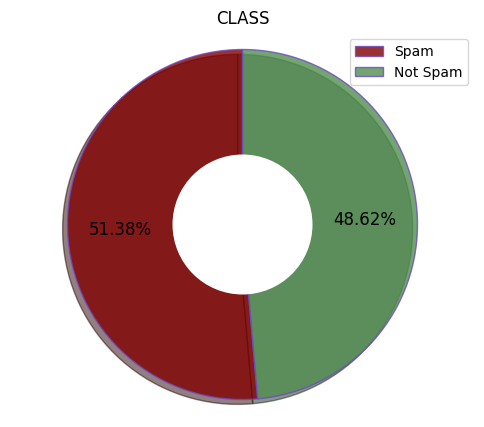

In [8]:
colors = ['#800000', '#508D4E']
plt.figure(figsize=(6, 5))
plt.pie(data['CLASS'].value_counts(), startangle=90,shadow=True,pctdistance=0.7,autopct='%.2f%%', wedgeprops=dict(alpha=0.8, edgecolor='#6C48C5'),textprops={'fontsize':12},colors=colors)
centre_circle = plt.Circle((0,0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title('CLASS')
plt.legend(labels=["Spam", "Not Spam"])
plt.show()

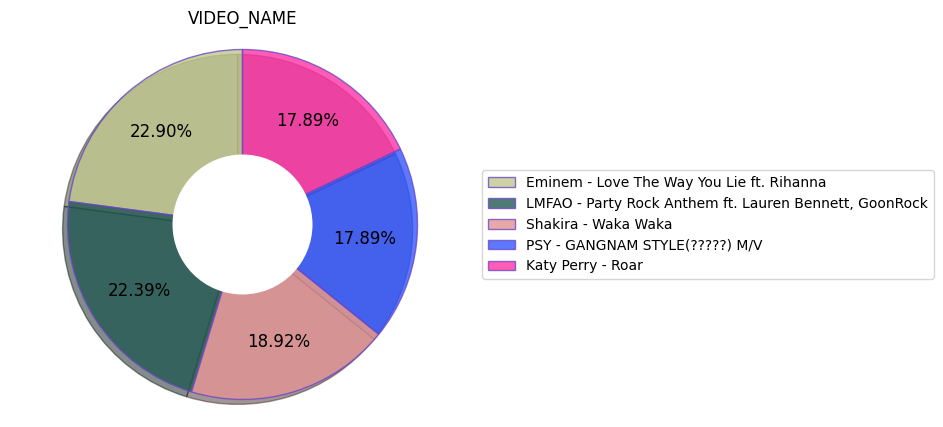

In [9]:
colors = ['#C0C78C', '#245953', '#E49393','#3357FF', '#FF33A6']

plt.figure(figsize=(6, 5))

plt.pie(data['VIDEO_NAME'].value_counts(), startangle=90, shadow=True, pctdistance=0.7, 
        autopct='%.2f%%', wedgeprops=dict(alpha=0.8, edgecolor='#6C48C5'), 
        textprops={'fontsize': 12}, colors=colors)

centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.title('VIDEO_NAME')

plt.legend(data['VIDEO_NAME'].value_counts().index.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


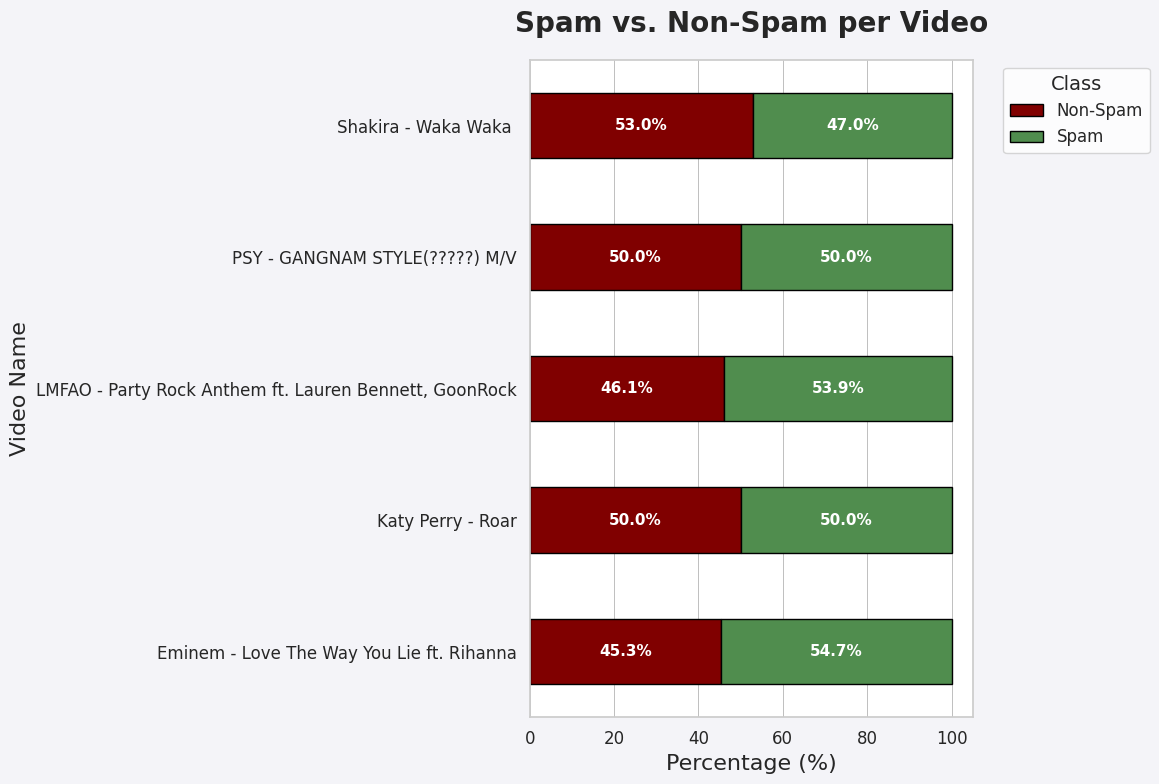

In [10]:
colors = ['#800000', '#508D4E']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 8), facecolor='#f4f4f8')

video_class = data.groupby(['VIDEO_NAME', 'CLASS']).size().unstack(fill_value=0)

per=video_class.div(video_class.sum(axis=1), axis=0) * 100

ax = per.plot(kind='barh', stacked=True, color=colors, edgecolor='black', linewidth=1, ax=plt.gca())

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=11, weight='bold', color='white')

ax.grid(True, which='major', axis='x', linestyle='-', linewidth=0.5, alpha=0.7, color='gray')
ax.grid(False, which='major', axis='y')  

ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(title='Class', labels=['Non-Spam', 'Spam'], fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

plt.title('Spam vs. Non-Spam per Video', fontsize=20, pad=20, weight='bold')
plt.ylabel('Video Name', fontsize=16)
plt.xlabel('Percentage (%)', fontsize=16)

plt.tight_layout()

plt.show()


/tmp/ipykernel_17/634973178.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=data_copy['Content_length'], hue=data_copy['CLASS'], shade=True, bw_adjust=.5)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pas

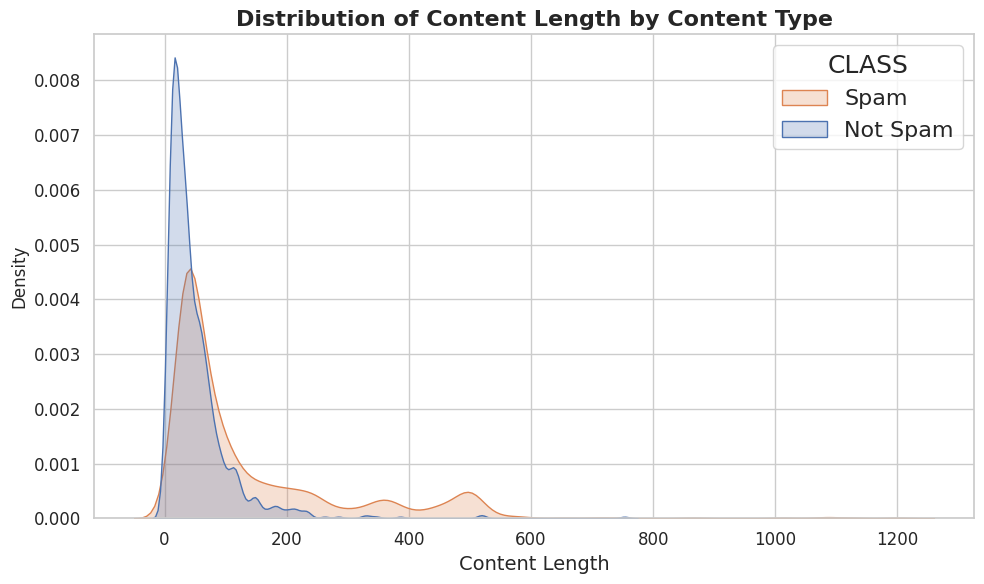

In [11]:
data_copy = data.copy()
data_copy['Content_length'] = data_copy['CONTENT'].str.len()
plt.figure(figsize=(10, 6))
sns.kdeplot(x=data_copy['Content_length'], hue=data_copy['CLASS'], shade=True, bw_adjust=.5)
plt.xlabel('Content Length', fontsize=14)
plt.title('Distribution of Content Length by Content Type', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='CLASS',labels=["Spam", "Not Spam"] ,fontsize=16, title_fontsize=18)
plt.tight_layout()
plt.show()

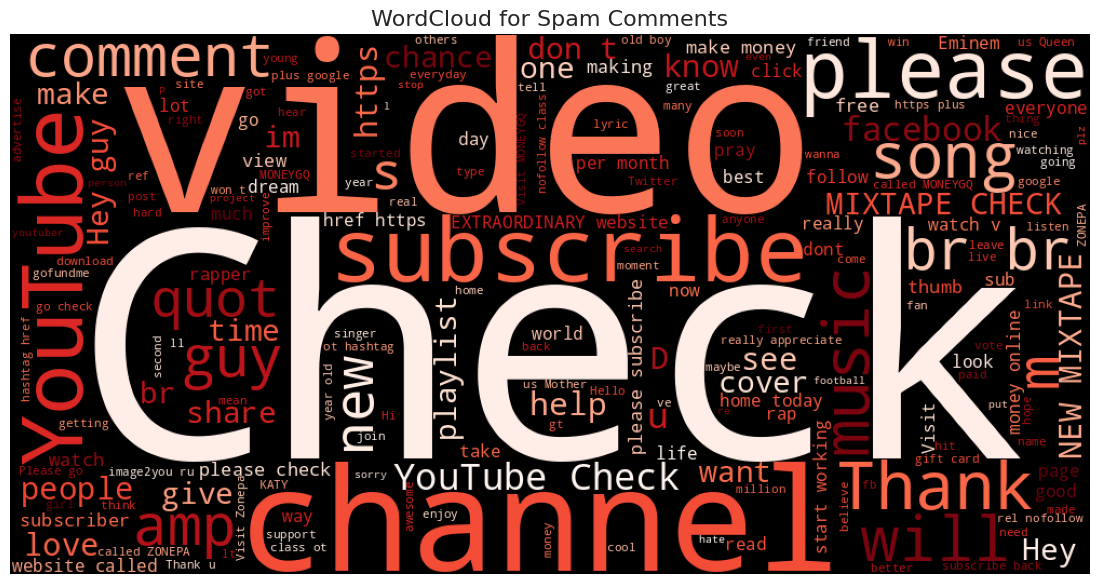

In [12]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 1000, height = 500, min_font_size = 10, background_color = 'black',colormap='Reds')
spam_wordcloud = wordcloud.generate(data[data['CLASS'] == 1]['CONTENT'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wordcloud)
plt.title('WordCloud for Spam Comments', fontsize=16)

plt.axis('off')
plt.tight_layout()  

plt.show()

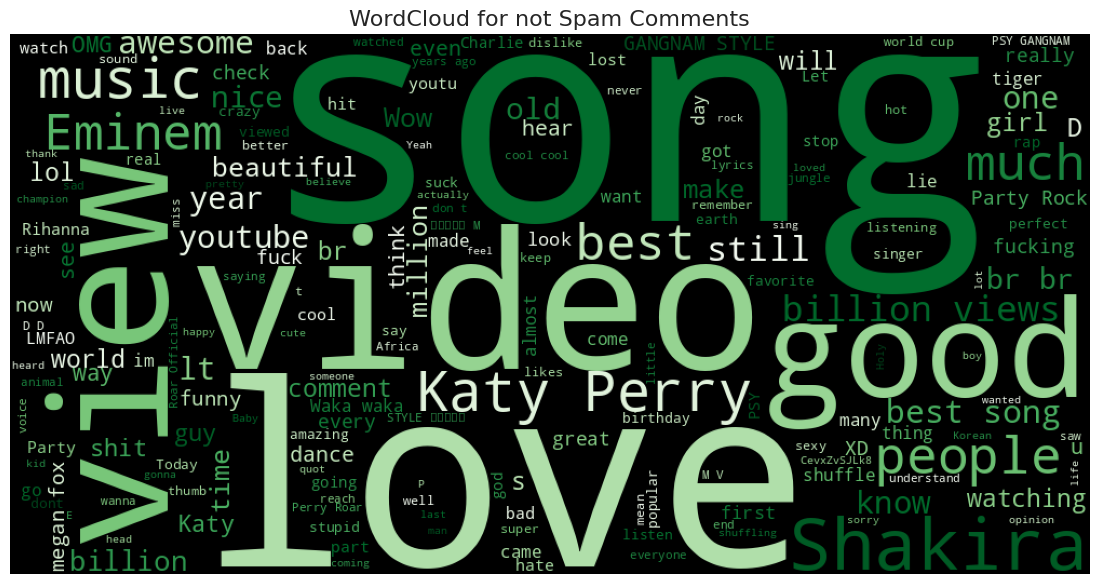

In [13]:
wordcloud = WordCloud(width = 1000, height = 500, min_font_size = 10, background_color = 'black',colormap='Greens')
spam_wordcloud = wordcloud.generate(data[data['CLASS'] == 0]['CONTENT'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wordcloud)
plt.title('WordCloud for not Spam Comments', fontsize=16)

plt.axis('off')
plt.tight_layout()  

plt.show()

# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Concatenation & Dropping Columns</p>

In [14]:
data['content']=data['VIDEO_NAME']+' '+data['CONTENT']

In [15]:
data.drop(columns=['VIDEO_NAME','CONTENT','COMMENT_ID','AUTHOR','DATE'],inplace=True)

In [16]:
data.head()

CLASS                                            content
0      1  PSY - GANGNAM STYLE(?????) M/V Huh, anyway che...
1      1  PSY - GANGNAM STYLE(?????) M/V Hey guys check ...
2      1  PSY - GANGNAM STYLE(?????) M/V just for test I...
3      1  PSY - GANGNAM STYLE(?????) M/V me shaking my s...
4      1  PSY - GANGNAM STYLE(?????) M/V watch?v=vtaRGgv...

# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Data Cleaning</p>

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '


<div style="font-family: 'Playfair Display', serif;  letter-spacing: 0px; color:#808D7C; font-size:120%; padding:10px; background: #FBF7F7; border-radius: 3px;">
    <p style="font-size: 110%;color: black;">To enhance the effectiveness of the classification process, I augmented the default stop words list in the SpaCy library and nltk with additional terms identified as frequently recurring in both spam and non-spam comments. These redundant words, considered insignificant for distinguishing between the two categories, were deemed unnecessary for the classification task.

</p>
</div>


In [19]:
stop_words=['music','youtube','video','i','u', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"'so', 'keep', 'when', "'m", 'do', 'either', 'them', 'whence', 'with', 'put', '‘ve', 'on', 'your', 'becoming', 'whereby', 'whose', 'each', 'amount', 'me', 'fifteen', 'mostly', 'show', 'would', 'next',  'there', 'nothing', 'she', 'but', 'for', 'here', 'why', 'these', 'further', 'between', 'eleven', 'than', 'am', 'beside', 'after', 'under', 'if','around', 'have', 'such', 'less', 'her', 'before', 'although', 'has', 'among', 'amongst', 'least', '’re', 'should', 'fifty', 'last', 'off', 'formerly', 'until', 'much', 'this', '’ll', 'get', 'perhaps', 'how', 'eight', 'any', 'indeed', 'you', 'myself', 'neither', 'seeming', 'beforehand', 'it', 'thru', 'out', 'call', 'forty', 'one', 'still', 'whereupon', 'wherever', 'over', 'also', 'former', 'namely', 'been', 'make', 'doing', 'regarding', 'he', 'due', 'other', 'bottom', 'sometimes', 'a', 'moreover', 'though', 'whether', 'seemed', 'too', "'re", 'could', 'part', 'everything', 'by', 'thus', 'anyway', 'into', 'go', 'nevertheless', 'anyhow', 'within', 'whoever', 'third', 'being', 'various', 'wherein', 'at', 'take', 'thereby', 'does', 'nine','what', 'almost', 'ever', 'my', 'name', 'yours', 'hereby', 'say', 'hereupon', 'and', 'twelve', 'becomes', 'about', 'own', '’m', 'beyond', 'just', 'above', 'full', 'very', 'besides', 'had', 'noone', 'anything', 'both', 'down', 'whenever', 'several', 'afterwards', 'are',  'because', 'might', 'upon', 'quite', 'done', 'to', 'top', 'really', 'were', 'across', 'yourself', 'others', 'only', 'anywhere', 'move', 'whatever', 'their', 'therein', 'everyone', 'everywhere', 'now', 'something', 'toward', 'however', 'see', 'alone', "'s", '’ve', 'its', 'back', 'our', 'itself', '’d', 'every', 'thereafter', 'whom', 'already', 'as', 'hers', 'where','behind', 'in', 'therefore', 'used', 'together', 'hereafter', 'ca', 'mine', 'many', 'else', 'onto', 'since', '’s', 'whither', 'somewhere', 'themselves', 'from', 'otherwise', 'sixty', 'twenty', 'is', 'two', 'towards', '‘s', 'ten', 'they', 'please', 'those', 'did',  'hundred', 'again', 'became', 'made', 'who', '‘re', 'herein', 'same', 'front', 'up', 'whereas', 'along', 'three', 'then', 'which', 'rather', 'via', 'empty', 'hence', 'seems', 'seem', 'was', 'well', 'meanwhile', 'someone', 'elsewhere', 'once', '‘d', 'the', 'latterly', 'using', 'sometime', 'some', 'whereafter', 'six', 'while', 'of', "'d", 'first', 'herself', 'us', 'be', 'we', 'become', 'often', 'i', 'all', 'another', 'side', 'five', '‘m',  'four', 'must', 'him','somehow', 'serious', "'ll", 'or', 'none', 'during', 'can', 'thence', 'through', 're', 'that', '‘ll', 'his', "'ve", 'throughout', 'always', 'may', 'give', 'will', 'whole', 'yourselves', 'latter', 'ourselves', 'nowhere', 'thereupon', 'an', 'per', 'ours','day','much']

In [20]:
stop_words=set(stop_words)

In [21]:
def clean_text(text):
  text=text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
  text = re.sub(r'\@\w+|\#','', text)
  text = re.sub(r'[^\x00-\x7F]+','', text)
  text=re.sub(r'[^a-zA-Z0-9\s]','',text)
  text=re.sub(r'\s+https\S+',' ',text)
  text=re.sub(r'\s+www\S+',' ',text)
  text=re.sub(r'\s+http\S+',' ',text)
  text=re.sub(r'\s+',' ',text)
  text=re.sub(r'\d+','',text)
  text=text.strip()
  words = nlp(text)
  words = [word.lemma_ for word in words]
  words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
  return ' '.join(words)


In [22]:
data['content']=data['content'].apply(clean_text)

# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Splitting</p>

In [23]:
x=data['content']
y=data['CLASS']

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Modeling</p>

In [25]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42))
])

param_grid = {
    'svm__C': [0.1,0.5, 1, 10, 100],  
    'svm__kernel': ['linear', 'rbf', 'poly'], 
    'svm__gamma': ['scale', 'auto'],  
    'svm__degree': [2, 3, 4,5], 
    'svm__class_weight': [None, 'balanced']  
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.3s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=linear; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=rbf; total time=   0.5s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=poly; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=poly; total time=   0.4s
[CV] END svm__C=0.1, svm__class_weight=None, svm__degree=2, svm__gamma=scale, svm__kernel=poly; total time=   0.4s
[CV] END sv

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 0.5, 1, 10, 100],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__degree': [2, 3, 4, 5],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=2)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       176
           1       0.96      0.93      0.94       216

    accuracy                           0.94       392
   macro avg       0.93      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



<Axes: >

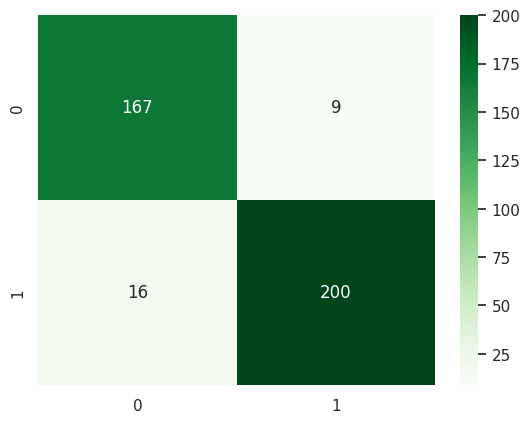

In [26]:
y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='', cmap='Greens')

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       176
           1       0.95      0.90      0.93       216

    accuracy                           0.92       392
   macro avg       0.92      0.92      0.92       392
weighted avg       0.92      0.92      0.92       392



<Axes: >

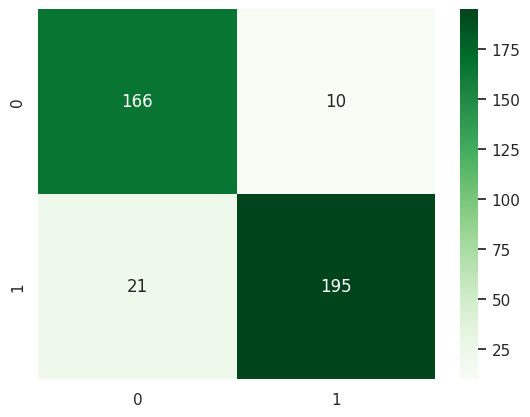

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf=Pipeline([('tfidf',TfidfVectorizer()),('RandomForestClassifier',RandomForestClassifier(random_state=43))])
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='', cmap='Greens')

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       176
           1       0.94      0.93      0.93       216

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



<Axes: >

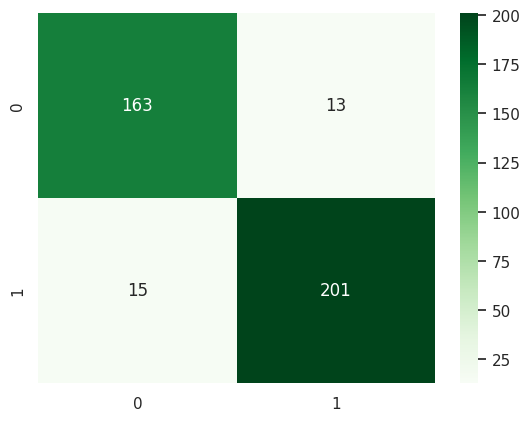

In [28]:
from sklearn.svm import LinearSVC
ls=Pipeline([('tfidf',TfidfVectorizer()),('LinearSVC',LinearSVC(random_state=42))])
ls.fit(x_train,y_train)
y_pred=ls.predict(x_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='', cmap='Greens')

# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Models Accuracy</p>

In [29]:
acc=[]
names=['SVC','RandomForest','LinearSVC']
acc.extend([grid_search.score(x_test,y_test),rf.score(x_test,y_test),ls.score(x_test,y_test)])
acc

[0.9362244897959183, 0.9209183673469388, 0.9285714285714286]

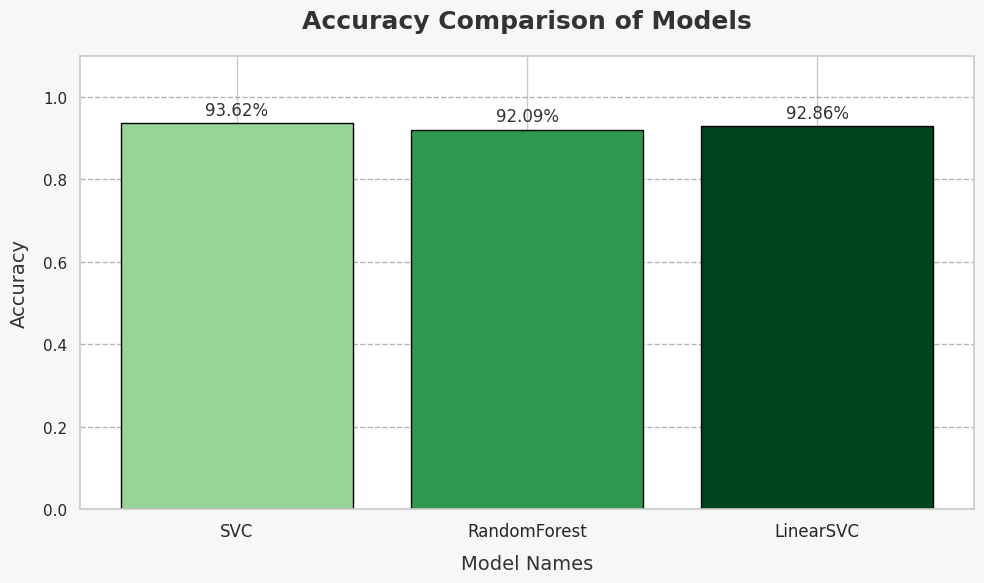

In [30]:
colors = plt.cm.Greens(np.linspace(0.4, 1, len(acc)))

plt.figure(figsize=(10, 6), facecolor='#f7f7f7')

bars = plt.bar(names, acc, color=colors, edgecolor='black')

plt.title('Accuracy Comparison of Models', fontsize=18, fontweight='bold', pad=20, color='#333333')
plt.xlabel('Model Names', fontsize=14, labelpad=10, color='#333333')
plt.ylabel('Accuracy', fontsize=14, labelpad=10, color='#333333')

plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval*100:.2f}%', ha='center', va='bottom', fontsize=12, color='#333333')

plt.ylim(0, 1.1)

plt.xticks( fontsize=12)

plt.tight_layout()

plt.show()


# <p style="background-color: #800000;font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; border-radius:5px 50px;">Testing Examples</p>

In [31]:
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]

In [32]:
not_spam_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]

In [33]:
spam_text=[clean_text(sent) for sent in spam_text ]
not_spam_text=[clean_text(sent) for sent in not_spam_text ]

In [34]:
not_spam_text

['love eminem',
 'think million view come people want check view',
 'psy gangnam style thumb check view']

In [35]:
pred = grid_search.predict(spam_text)
for i in range(len(spam_text)):
    if pred[i] < 0.5:
        print('Not Spam')
    else:
        print('Spam')

Spam
Spam
Spam
Spam


In [36]:
pred = grid_search.predict(not_spam_text)
for i in range(len(not_spam_text)):
    if pred[i] < 0.5:
        print('Not Spam')
    else:
        print('Spam')

Not Spam
Not Spam
Not Spam


# <div style="font-family: 'Verdana', sans-serif; color:#FFFFFF; font-size:140%; font-family:Monospace; text-align:center; padding:10px; background: #800000; border-radius: 25px;" > The End</div>  